In [195]:
# This Notebook is for measuring the popularity of test items
from experiments.data_loader import DataLoader
from shared.enums import Sentiment
import numpy as np
from scipy import stats 
from matplotlib import pyplot as plt 
import seaborn as sns

data_loader = DataLoader('../../data/default/split_0')

entity_ratings = dict()

for user, ratings in data_loader.training().items():
    for item, rating in ratings.training.items():
        entity_ratings[item] = entity_ratings.get(item, 0) + 1
        pass

print(entity_ratings)

{13966: 324, 7110: 634, 236: 21, 11360: 197, 9905: 607, 7165: 427, 9742: 369, 18533: 255, 7296: 605, 3089: 535, 6431: 17, 12026: 22, 16807: 3, 6134: 41, 16200: 530, 18048: 36, 1366: 120, 11622: 3, 3852: 1, 13260: 1, 10532: 26, 1425: 32, 2479: 202, 4395: 84, 3419: 19, 12586: 5, 9699: 2, 18249: 20, 10680: 10, 14493: 4, 12563: 6, 13335: 76, 1379: 403, 18665: 11, 1648: 544, 17140: 156, 16628: 201, 15102: 315, 4197: 284, 8059: 15, 17053: 18, 6706: 18, 16830: 50, 15487: 89, 2317: 15, 382: 18, 11468: 53, 1020: 10, 14652: 14, 17863: 21, 3010: 19, 16397: 8, 1701: 2, 15946: 2, 1944: 253, 5836: 175, 12499: 133, 11541: 412, 9687: 30, 5026: 163, 3000: 19, 7511: 34, 13672: 54, 14242: 33, 17777: 25, 3991: 15, 803: 10, 9502: 64, 14710: 9, 14122: 18, 652: 9, 17458: 17, 7332: 1, 8219: 70, 9636: 46, 8600: 61, 6984: 122, 14109: 112, 18319: 7, 110: 14, 6950: 16, 4668: 23, 6654: 56, 4646: 22, 11533: 108, 120: 32, 1896: 29, 8290: 8, 5408: 16, 4887: 51, 6898: 18, 17823: 21, 209: 35, 10486: 15, 5075: 31, 13008

DescribeResult(nobs=241, minmax=(0, 108), mean=20.53112033195021, variance=454.7667358229599, skewness=1.5658934302961691, kurtosis=2.1879746825672513)
np.median(positive_ratings)=13.0
DescribeResult(nobs=24100, minmax=(0, 108), mean=15.41045643153527, variance=300.5350331955373, skewness=2.0352002442697477, kurtosis=5.080716793995501)
np.median(unseen_ratings)=9.0
11.0
1.0


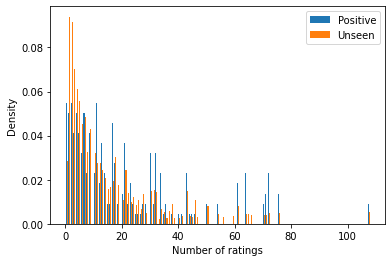

In [196]:
# How popular are positive items compared to unseen samples

positive_ratings = list()
unseen_ratings = list()

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        unseen_items = cold_set.ranking.sentiment_samples[Sentiment.UNSEEN]
        
        for item in positive_items:
            positive_ratings.append(entity_ratings.get(item, 0))
            
        for item in unseen_items:
            unseen_ratings.append(entity_ratings.get(item, 0))
                
        break
            
print(stats.describe(positive_ratings))
print(f'{np.median(positive_ratings)=}')
print(stats.describe(unseen_ratings))
print(f'{np.median(unseen_ratings)=}')

print(f'{np.percentile(positive_ratings, 45)}')
print(f'{np.percentile(unseen_ratings, 3)}')
plt.hist([positive_ratings, unseen_ratings], bins=119, label=['Positive', 'Unseen'], density=True)
plt.legend(loc='upper right')
plt.xlabel('Number of ratings')
plt.ylabel('Density')
plt.xlim([0, 30])
plt.savefig('sampling_popularity_bias.pdf', bbox_inches='tight')

In [197]:
# How many unique positive samples we have per test user
test_ratings = dict()
unseen_ratings = dict()
lengths = []

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        
        items.update(positive_items)

    lengths.append(len(items))

print(stats.describe(lengths))

DescribeResult(nobs=241, minmax=(2, 10), mean=6.3112033195020745, variance=2.581915629322268, skewness=0.06563450760683821, kurtosis=-0.2387094909287235)
